In [3]:
# Configure Autoreload
%load_ext autoreload
%autoreload 2

# Add parent directory to system path
import os, sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import graph.graph_db as graph_db
import seaborn as sns
import os
import sys

# Add parent directory to system path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from itertools import count, islice

import graphblas_algorithms as blas
import networkx as nx
import numpy as np

from algorithms import *

import graph.graph_db as graph_db
import synthesis.edge_addition_generator as eag
import synthesis.graph_generator as graph_generator
import synthesis.weight_generator as weight_generator
from algorithms.ga import GeneticSolver
from algorithms.greedy import GreedySolver
from algorithms.sa import SimulatedAnnealingSolver
from algorithms.montecarlo import MonteCarloSolver
from algorithms.solver import ProblemTooBigException
from graph import EdgeSet, dynamic_aspl, model
from synthesis.problem_generator import generate_problem
from graph import dynamic_aspl
from synthesis.weight_generator import MetaWeighter, UniformWeighter, Uniform 
from itertools import islice, count
from synthesis.combinations import find_closest_nCr, find_nCr_from_complexity
import matplotlib.pyplot as plt
import pandas as pd
from synthesis.randomisation import TruncatedNormal, RandomChoice
from analysis import visualisation

## Medium Graphs - Greedy and Exhaustive

Graph named 'WattsStrogatzGraph' with 50 nodes and 50 edges
{'generation_parameters': {'n': 50, 'k': 2, 'p': 0.5}, 'class': 'WattsStrogatzGraph', 'density': 0.04081632653061224, 'name': 'WattsStrogatzGraph', 'weighter_class': 'Uniform Weighter', 'weighter': Uniform Weighter with parameters {'a': 1.0, 'b': 10000.0}}
Updating Graph id 468
Problem Instance 468 |S|=141, k=6 with 9798689908 possible solutions


Greedy Solver: 100%|██████████| 6/6 [00:00<00:00, 495.13it/s]


Solution generated by 'Greedy Solver' with 6 edges and ASPL 17402.636534066125
Reason for termination: iterations_exhausted




Monte Carlo Solver: 100%|██████████| 100000/100000 [00:06<00:00, 16385.48it/s, best_aspl=19395.59868964365, aspl=36490.34398513205, solutions_explored=100000]


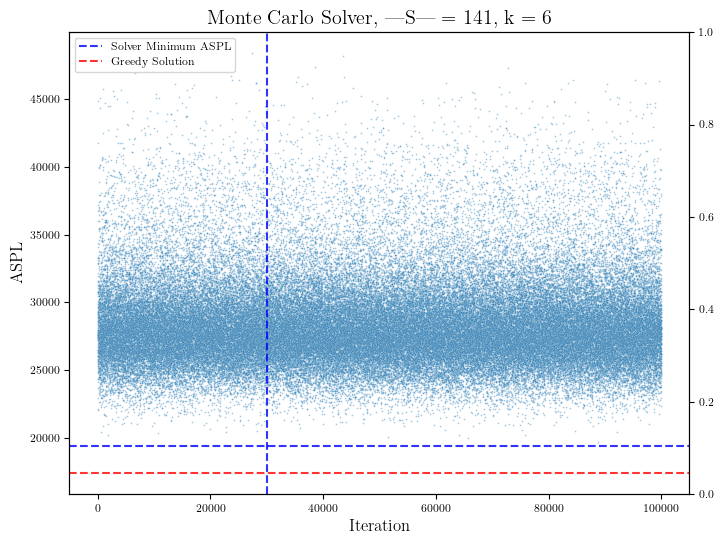

Solution generated by 'Monte Carlo Solver' with 6 edges and ASPL 19395.59868964365
Reason for termination: iterations_exhausted




Genetic Solver:  68%|██████▊   | 68/100 [00:05<00:02, 13.11it/s, best_aspl=17374.412, aspl=17397.62, solutions_explored=20636] 


50000 50673


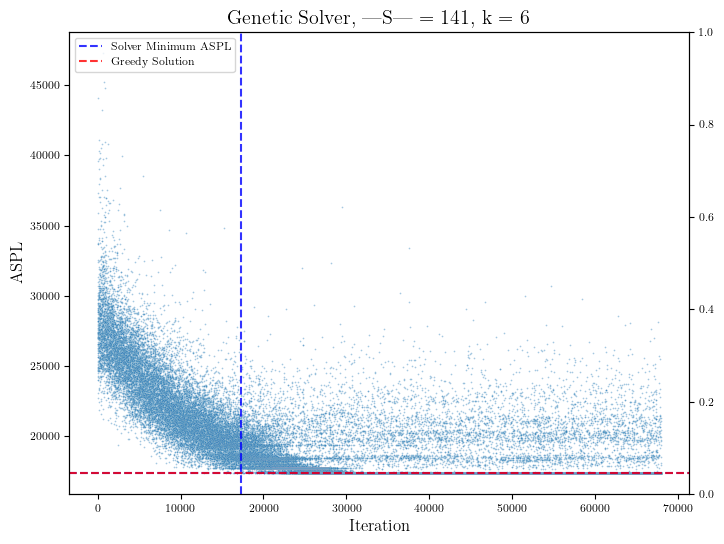

KeyboardInterrupt: 

In [6]:
from synthesis.randomisation import UniformInteger, TruncatedGaussianMixture
from synthesis.graph_generator import *
maximum_time = 120
iterations = 100000
ga_pool_size = 1000

experiment_name = "2024-05-10a"
experiment_description = "Random graphs with 100-300 nodes, 40-1000 edges, and 0.3-0.7 edge probability. 1000 iterations of each solver."

ga_iterations = iterations // ga_pool_size
weighter = UniformWeighter(1,10000)
#n = UniformInteger(20, 100)
n = 50
#N = 1e10
#n = TruncatedNormal(200, 50, a=100, b=300)
N = TruncatedNormal(1e10, 1e4, a=1e6, b=1e15)

graph_generator = RandomGraphGenerator(generators = [
    #ErdosRenyiGraph(n=n, p=RandomChoice([0.001, 0.3]), weighter=weighter),
    WattsStrogatzGraph(n=n, k=RandomChoice([2]), p=RandomChoice([0.1,0.5,0.9]), weighter=weighter),
    #BarabasiAlbertGraph(n=n, m=RandomChoice([1,10]), weighter=weighter),
    #RandomRegularGraph(n=n, d=RandomChoice([2,10]), weighter=weighter),
])

solvers = [
    #ExhuastiveSolver(early_stopping=False),
    GreedySolver(),
    MonteCarloSolver(maximum_time=30, maximum_iterations=100000, early_stopping=False),
    #GeneticSolver(patience=50000, population_size=1000, maximum_time=maximum_time, creature_mutation_rate=0.25, gene_mutation_rate=0.2, selection_method="roulette", maximum_iterations=ga_iterations),
    GeneticSolver(patience=50000, population_size=ga_pool_size, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="ranking", maximum_iterations=ga_iterations),
    SimulatedAnnealingSolver(method_name = 'Exponential Simulated Annealing Solver', patience=50000,  maximum_time=maximum_time, maximum_iterations = 50000, acceptance_method='metropolis-hastings', annealing_schedule="exponential", initial_temperature=None, minimum_temperature=0.001),
    SimulatedAnnealingSolver(method_name = 'Adaptive Simulated Annealing Solver', patience=50000, maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', acceptance_window=200, annealing_schedule="adaptive", initial_temperature=1000, minimum_temperature=0.001),
]

problems = []
with graph_db.open('../data/graph.db') as db:
    for i in range(500):
        try:
            G = next(graph_generator)
            print(G)
            print(G.graph)
            #nx.draw(G)
            n = nx.number_of_nodes(G)
            
            S_degree_max = min(len(list(nx.non_edges(G))), 200)
            if S_degree_max < 2:
                print("Skipping graph - no non-edges.")
                continue
            S_degree, k = find_closest_nCr(int(N), S_degree_max)
            #k = S_degree - k

            problem = generate_problem(G, k, S_degree)
            problem.experiment_name = experiment_name
            problem.description = experiment_description
            problems.append(problem)
            db.write_problem(problem)
            print(problem)

            for solver in solvers:
                sln = solver.solve(problem)
                # Visualise the solution, if it has a decent number of iterations.
                if len(sln.trace) > 100:
                    visualisation.plot_trace(sln, "")
                db.write_solution(sln)
                print(sln)
                print(f"Reason for termination: {sln.termination_reason}")
                print("\n")
            print("\n\n\n")
        except Exception as e:
            raise e

In [53]:
with graph_db.open('../data/graph.db') as db:
    p = db.read_problem(1)

In [56]:
p.solutions[2].trace

[{'best_aspl': 28314.396734693877,
  'aspl': 28314.396734693877,
  'solutions_explored': 1},
 {'best_aspl': 23522.37714285714,
  'aspl': 23522.37714285714,
  'solutions_explored': 2},
 {'best_aspl': 23522.37714285714,
  'aspl': 25889.642448979594,
  'solutions_explored': 3},
 {'best_aspl': 23522.37714285714,
  'aspl': 25052.03918367347,
  'solutions_explored': 4},
 {'best_aspl': 23522.37714285714,
  'aspl': 31953.49551020408,
  'solutions_explored': 5},
 {'best_aspl': 23522.37714285714,
  'aspl': 29768.62693877551,
  'solutions_explored': 6},
 {'best_aspl': 23522.37714285714,
  'aspl': 30376.395102040817,
  'solutions_explored': 7},
 {'best_aspl': 23522.37714285714,
  'aspl': 29807.111836734693,
  'solutions_explored': 8},
 {'best_aspl': 23522.37714285714,
  'aspl': 32727.219591836736,
  'solutions_explored': 9},
 {'best_aspl': 23522.37714285714,
  'aspl': 29814.354285714286,
  'solutions_explored': 10},
 {'best_aspl': 23522.37714285714,
  'aspl': 30690.82775510204,
  'solutions_explor

## Big Graphs

Graph named 'RandomRegularGraph' with 833 nodes and 833 edges
{'generation_parameters': {'n': 1000, 'd': 2}, 'class': 'RandomRegularGraph', 'density': 0.002403846153846154, 'name': 'RandomRegularGraph', 'weighter_class': 'Uniform Weighter', 'weighter': Uniform Weighter with parameters {'a': 1.0, 'b': 10000.0}}
Problem Instance |S|=88, k=21 with 99542918594662008840 possible solutions


Greedy Solver: 100%|██████████| 21/21 [00:02<00:00,  7.93it/s]


Solution generated by 'Greedy Solver' with 21 edges and ASPL 140827.0207775418
Reason for termination: iterations_exhausted




Monte Carlo Solver:   3%|▎         | 2600/100000 [00:59<37:22, 43.44it/s, best_aspl=171869.46163080618, aspl=217018.49773755655, solutions_explored=2600]


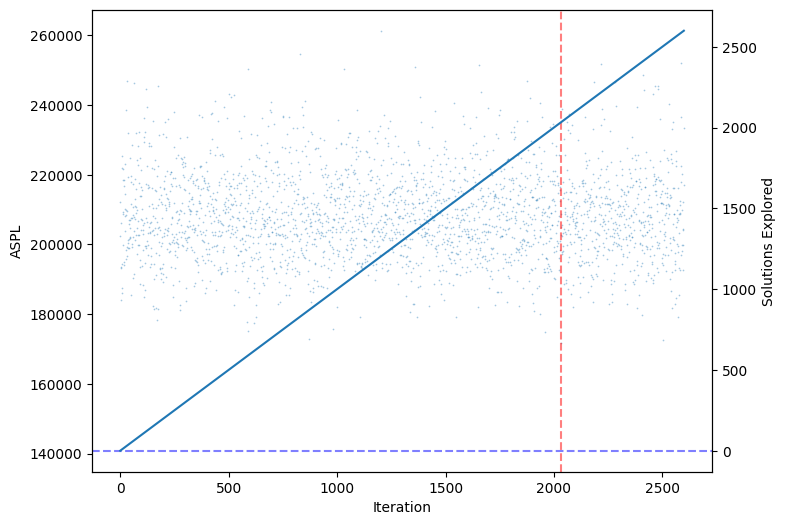

Solution generated by 'Monte Carlo Solver' with 21 edges and ASPL 171869.46163080618
Reason for termination: time_limit_reached




Genetic Solver:   2%|▏         | 20/1000 [29:39<24:13:01, 88.96s/it, best_aspl=148471.97, aspl=162137.11, solutions_explored=19975] 


Solution generated by 'Genetic Solver' with 21 edges and ASPL 148471.96875
Reason for termination: time_limit_reached




Simulated Annealing Solver:  87%|████████▋ | 43287/50000 [16:34<02:34, 43.52it/s, best_aspl=128715.31775787238, aspl=128715.31775787238, solutions_explored=43287, temperature=0.08495708062678002, log_acceptance_probability=-82383.28410057575, delta=6999.043309631539]   


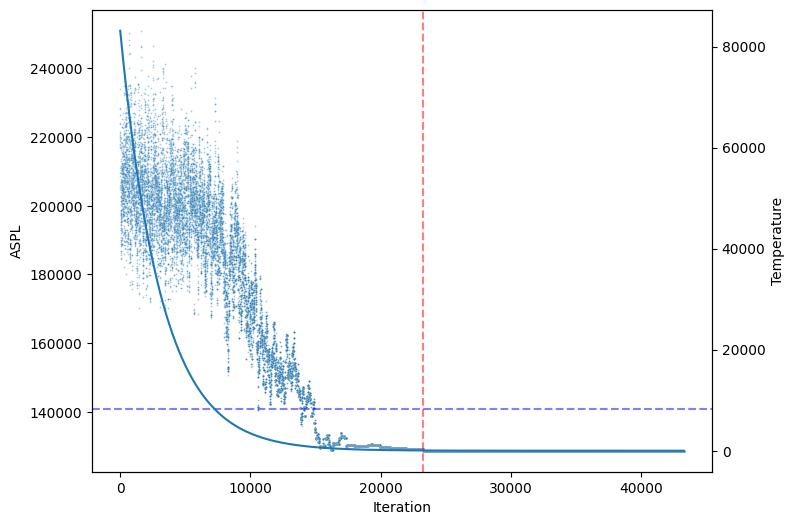

Solution generated by 'Simulated Annealing Solver' with 21 edges and ASPL 128715.31775787238
Reason for termination: early_stopping




Simulated Annealing Solver:   1%|          | 8200/1000000 [03:22<6:48:59, 40.42it/s, best_aspl=132211.328839228, aspl=132211.328839228, solutions_explored=8201, temperature=0.010176388788859743, log_acceptance_probability=-642256.1765683963, delta=6535.848554806551]     


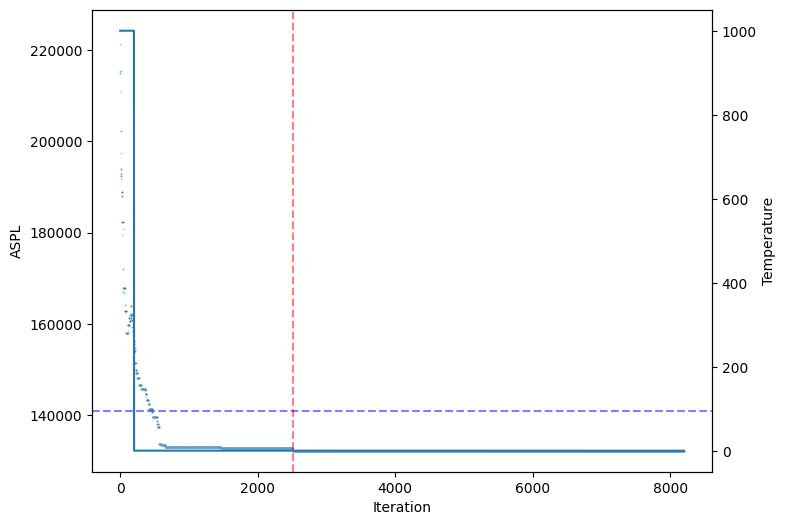

Solution generated by 'Simulated Annealing Solver' with 21 edges and ASPL 132211.328839228
Reason for termination: unknown






Graph named 'RandomRegularGraph' with 727 nodes and 727 edges
{'generation_parameters': {'n': 1000, 'd': 2}, 'class': 'RandomRegularGraph', 'density': 0.0027548209366391185, 'name': 'RandomRegularGraph', 'weighter_class': 'Uniform Weighter', 'weighter': Uniform Weighter with parameters {'a': 1.0, 'b': 10000.0}}
Problem Instance |S|=88, k=21 with 99542918594662008840 possible solutions


Greedy Solver: 100%|██████████| 21/21 [00:02<00:00,  9.92it/s]


Solution generated by 'Greedy Solver' with 21 edges and ASPL 132556.42575056554
Reason for termination: iterations_exhausted




Monte Carlo Solver:   3%|▎         | 3198/100000 [00:59<30:11, 53.43it/s, best_aspl=155687.40774760232, aspl=201252.57323011282, solutions_explored=3198]


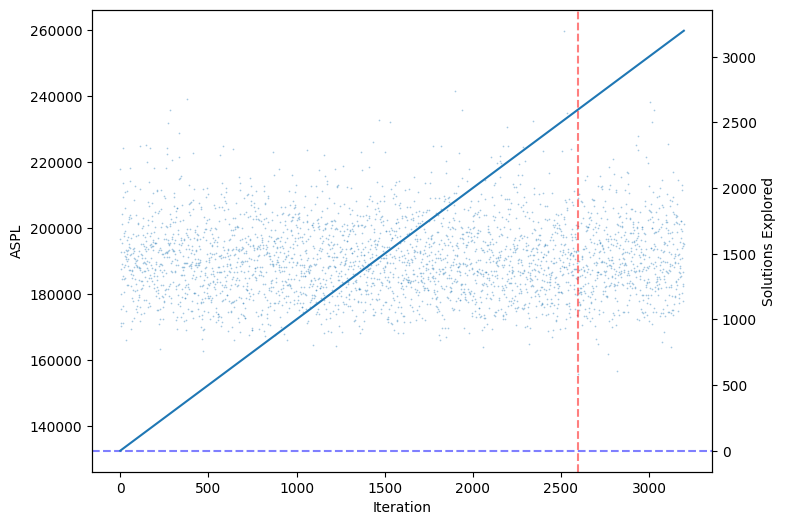

Solution generated by 'Monte Carlo Solver' with 21 edges and ASPL 155687.40774760232
Reason for termination: time_limit_reached




Genetic Solver:   7%|▋         | 66/1000 [20:10<4:45:25, 18.34s/it, best_aspl=123911.04, aspl=125046.35, solutions_explored=48274] 


Solution generated by 'Genetic Solver' with 21 edges and ASPL 123911.0390625
Reason for termination: time_limit_reached




Simulated Annealing Solver:  30%|██▉       | 14903/50000 [04:40<11:01, 53.08it/s, best_aspl=128255.37819106407, aspl=134910.25874096726, solutions_explored=14903, temperature=668.9219880374569, log_acceptance_probability=-12.105797699018062, delta=8097.8342636064335]   


KeyboardInterrupt: 

In [78]:
from synthesis.randomisation import UniformInteger, TruncatedGaussianMixture
from synthesis.graph_generator import *
maximum_time = 1200
iterations = 1000000
ga_pool_size = 1000

experiment_name = "Big Graphs with Exhaustive and Greedy Solutions - 2024-05-08b"
experiment_description = "Random graphs with 100-300 nodes, 40-1000 edges, and 0.3-0.7 edge probability. 1000 iterations of each solver."

ga_iterations = iterations // ga_pool_size
weighter = UniformWeighter(1,10000)
#n = UniformInteger(20, 100)
n = 1000
#N = int(TruncatedNormal(1e5, 1e2, a=1e4, b=1e7))
N = 1e20
graph_generator = RandomGraphGenerator(generators = [
    #ErdosRenyiGraph(n=n, p=TruncatedGaussianMixture(means=[0.3, 0.7], stds=[0.1,0.1], weights=[1,1], a=0, b=1), weighter=weighter),
    #WattsStrogatzGraph(n=n, k=UniformInteger(10,20), p=Uniform(0,1), weighter=weighter),
    #BarabasiAlbertGraph(n=n, m=UniformInteger(1,40), weighter=weighter),
    RandomRegularGraph(n=n, d=2, weighter=weighter),
])

solvers = [
    #ExhuastiveSolver(early_stopping=False),
    GreedySolver(),
    MonteCarloSolver(maximum_time=60, maximum_iterations=100000, early_stopping=False),
    #GeneticSolver(patience=50000, population_size=1000, maximum_time=maximum_time, creature_mutation_rate=0.25, gene_mutation_rate=0.2, selection_method="roulette", maximum_iterations=ga_iterations),
    GeneticSolver(population_size=ga_pool_size, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="ranking", maximum_iterations=ga_iterations),
    SimulatedAnnealingSolver(patience=20000,  maximum_time=maximum_time, maximum_iterations = 50000, acceptance_method='metropolis-hastings', annealing_schedule="exponential", initial_temperature=None, minimum_temperature=0.01),
    SimulatedAnnealingSolver(maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', acceptance_window=200, annealing_schedule="adaptive", initial_temperature=1000, minimum_temperature=0.01),
]

problems = []
with graph_db.open('../data/graph.db') as db:
    for G in graph_generator:
        print(G)
        print(G.graph)
        #nx.draw(G)
        n = nx.number_of_nodes(G)
        
        S_degree_max = min(len(list(nx.non_edges(G))), 200)
        if S_degree_max < 2:
            print("Skipping graph - no non-edges.")
            continue
        S_degree, k = find_closest_nCr(1e20, S_degree_max)
        #k = S_degree - k

        problem = generate_problem(G, k, S_degree)
        problem.experiment_name = experiment_name
        problem.description = experiment_description
        problems.append(problem)
        #db.write_problem(problem)
        print(problem)

        for solver in solvers:
            sln = solver.solve(problem)
            # Visualise the solution, if it has a decent number of iterations.
            if sln.iterations > 100:
                visualisations.plot_trace(sln, "")
            #db.write_solution(sln)
            print(sln)
            print(f"Reason for termination: {sln.termination_reason}")
            print("\n")
        print("\n\n\n")


In [ ]:
from synthesis import combinations
combinations.find_closest_nCr(1e7, 200)

(125, 4)

In [41]:
find_closest_nCr(100000000, 20, 10)

(20, 10)

In [46]:
import math
math.comb(60, 50)

75394027566

In [ ]:
solver.solve(problem)

In [ ]:
from synthesis.randomisation import UniformInteger, TruncatedGaussianMixture
from synthesis.graph_generator import *
maximum_time = 180
iterations = 1000000
ga_pool_size = 1000

experiment_name = "Random Graphs with no Known Solution - 2024-05-08a"
experiment_description = "Random graphs with 100-300 nodes, 40-1000 edges, and 0.3-0.7 edge probability. 1000 iterations of each solver."

ga_iterations = iterations // ga_pool_size
#weighter = MetaWeighter
weighter = UniformWeighter(1,1000)
n = TruncatedNormal(100, 300, a=40, b=1000)
#n = TruncatedNormal(30, 10, a=10, b=50)
p = TruncatedGaussianMixture(means=[0.3, 0.7], stds=[0.1,0.1], weights=[1,1], a=0, b=1)
graph_generator = RandomGraphGenerator(generators = [
    ErdosRenyiGraph(n=n, p=p, weighter=weighter),
    WattsStrogatzGraph(n=n, k=UniformInteger(1,40), p=Uniform(0,1), weighter=weighter),
    BarabasiAlbertGraph(n=n, m=UniformInteger(1,10), weighter=weighter)
])

solvers = [
    #ExhuastiveSolver(early_stopping=False),
    GreedySolver(),
    MonteCarloSolver(maximum_time=30, early_stopping=False),
    #GeneticSolver(patience=50000, population_size=1000, maximum_time=maximum_time, creature_mutation_rate=0.25, gene_mutation_rate=0.2, selection_method="roulette", maximum_iterations=ga_iterations),
    GeneticSolver(population_size=ga_pool_size, maximum_time=maximum_time, creature_mutation_rate=0.15, gene_mutation_rate=0.2, selection_method="ranking", maximum_iterations=ga_iterations),
    SimulatedAnnealingSolver(patience=20000,  maximum_time=maximum_time, maximum_iterations = 50000, acceptance_method='metropolis-hastings', annealing_schedule="exponential", initial_temperature=None, minimum_temperature=0.01),
    SimulatedAnnealingSolver(maximum_time=maximum_time, maximum_iterations = iterations, acceptance_method='metropolis-hastings', acceptance_window=200, annealing_schedule="adaptive", initial_temperature=1000, minimum_temperature=0.01),
]

problems = []
with graph_db.open('../data/graph.db') as db:
    for G in graph_generator:
        print(G)
        print(G.graph)
        print(G.graph['weighter'])
        #nx.draw(G)
        n = nx.number_of_nodes(G)
        N = int(UniformInteger(1e7, 1e15))
        S_degree_max = min(len(list(nx.non_edges(G))), 200)
        S_degree, k = find_closest_nCr(N, S_degree_max)
        problem = generate_problem(G, k, S_degree)
        problem.experiment_name = experiment_name
        problem.description = experiment_description
        problems.append(problem)
        db.write_problem(problem)
        print(problem)

        for solver in solvers:
            sln = solver.solve(problem)
            #plot_trace(sln)
            db.write_solution(sln)
            print(sln)
            print(f"Reason for termination: {sln.termination_reason}")
            print("\n")
        print("\n\n\n")


In [ ]:
problems[-2].solutions[1].trace

In [ ]:
for problem in problems:
    for sln in problem.solutions:
        print(sln)
        print(f"Reason for termination: {sln.termination_reason}")
        print("\n")
        plot_trace(sln)
        print("\n\n\n")

In [ ]:
edge_data = []
for u, v in G.edges:
    data = G.get_edge_data(u, v)
    edge_data.append(data['weight'])
edge_data

In [ ]:
min(edge_data)

In [ ]:
maximum_time = 240
iterations = 20000
ga_pool_size = 200
n = 500
N = int(1e15)
S_degree_max =  100

ga_iterations = iterations // ga_pool_size
from synthesis.graph_generator import WattsStrogatzGraph, RandomRegularGraph
greedy = GreedySolver()
exhaustive = ExhuastiveSolver(maximum_time=maximum_time)
mc = MonteCarloSolver(maximum_iterations=iterations, maximum_time=maximum_time)
ga = GeneticSolver(repititions=5, population_size=ga_pool_size, maximum_time=maximum_time, maximum_iterations=ga_iterations, creature_mutation_rate=0.1, gene_mutation_rate=0.1, selection_method='ranking')
#graph = WattsStrogatzGraph(n=n, k=2, p=0.3)
graph = (n=n, d=10)
#weighter = weight_generator.GaussianWeighter(mu=100, sigma=50)
weighter = weight_generator.UniformWeighter(1, 1000)


G = next(graph)
print(G)
nx.draw(G)
weighter.weight_graph(G)
S_degree_max = min(len(list(nx.non_edges(G))), S_degree_max)
S_degree, k = find_closest_nCr(N, S_degree_max)
problem = generate_problem(G, k, S_degree)
#problem = eag.generate_problem_with_solution(G, k, S_degree, weighter=weighter)
print(problem)
print(problem.solutions)

#exhaustive_solution = next(exhaustive.solve(problem))

greedy_solution = next(greedy.solve(problem))
print(greedy_solution)
mc_solution = next(mc.solve(problem))
print(mc_solution)
ga_solutions = list(ga.solve(problem))


# Plot -----------------
# Merge the GA solutions together for CI estimation.
# Iterate through each GA trace and add a solution column
combined_traces = []
for rep, sln in enumerate(ga_solutions):
    for i, step in enumerate(sln.trace):
        step['i'] = i
        step['rep'] = rep
        combined_traces.append(step)
df = pd.DataFrame.from_records(combined_traces, exclude=['edge_hits'])

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

y_min = min(greedy_solution.aspl, mc_solution.aspl, df['aspl'].min()) * 0.995
y_max = max(greedy_solution.aspl, mc_solution.aspl) * 1.02
ax1.set_ylim(y_min, y_max)

sns.scatterplot(df, s=1.5, x="i", y="aspl", alpha=0.4, ax=ax1)
sns.lineplot(df, x="i", y="solutions_explored", errorbar=('sd'), ax=ax2)
ax1.axhline(y=greedy_solution.aspl, color='red', linestyle='--', linewidth=1.5)
ax1.axhline(y=mc_solution.aspl, color='red', linestyle='--', linewidth=1.5,)
plt.show()

In [ ]:
sorted(greedy_solution.edges)

In [ ]:
greedy_solution.edges.sum_of_weights

In [ ]:
sorted(ga_solutions[0].edges)

In [ ]:
ga_solutions[0].edges.sum_of_weights

In [ ]:
greedy_solution.edges == problem.solutions[2].edges

In [ ]:
df

In [ ]:


df = pd.DataFrame.from_records(solution.trace)
df['iteration'] = df.index
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
sns.scatterplot(df, s=1.5, x="iteration", y="aspl", alpha=0.4, ax=ax1)
sns.lineplot(df, x="iteration", y="solutions_explored", n_boot=0, estimator=None, ax=ax2)
plt.show()

In [ ]:
g = sns.FacetGrid(df, row="method", sharey=False)
g.map(sns.histplot, "aspl", stat="count")

In [ ]:
sns.histplot(df[df['method'] == 'Genetic Solver'].aspl)

In [ ]:
#sns.lineplot(df, x="iteration", y="aspl", hue="method", errorbar=('ci', 95), n_boot=10)  #estimator=None
plt = sns.lineplot(df, x="iteration", y="best_aspl", hue="method", errorbar=('sd'), n_boot=0)
plt.set_xlim(0,50000);

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
sns.scatterplot(df[df.method=='Genetic Solver'], s=0.1, x="iteration", y="aspl", hue="method", alpha=0.2, ax=ax1)
sns.lineplot(df[df.method=='Genetic Solver'], hue="solution", x="iteration", y="solutions_explored", n_boot=0, estimator=None, ax=ax2)
plt.show()


In [ ]:
plt = sns.kdeplot(df[df.method=='Genetic Solver'], x="iteration", y="aspl", fill=True, cmap='viridis')


